# Teams_ModelDev_Calculator


## Import libraries

In [0]:
# just run this chunk of code and follow the prompt that it spits out
# install PyDrive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# import packages
import warnings

# EDA
import itertools
from statistics import mean 
import scipy
import scipy.stats as st
import statsmodels.api as sm
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# preprocessing
import numpy as np
from numpy import unique
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# ensemble methods
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.classifier import StackingCVClassifier

# print model results
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, \
confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# save models for production
import pickle

# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Read cleaned files

In [0]:
# Teams version 3 data
link = 'https://drive.google.com/open?id=1_PktzNW5-6cbf5nHBXvSCs4Y94UA6ck7'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Teams_v3.csv')  
Teams_df = pd.read_csv('Teams_v3.csv')

print(Teams_df.shape)

(10886, 50)


## Filter data with features selected from EDA scripts

In [0]:
features_selected = ['d', 'kpm','ft','teamtowerkills','fbarontime','elementals',
'wcpm','minionkills','xpat10','gdiffat15','result'] 
Teams_df = Teams_df[features_selected]
Teams_df.head()

,d,kpm,ft,teamtowerkills,fbarontime,elementals,wcpm,minionkills,xpat10,gdiffat15,result
0,18.0,0.118188,1.0,4.0,21.536467,0.0,0.709127,691.0,18625.0,-3854.0,0
1,3.0,0.709127,0.0,10.0,21.536467,2.0,1.063690,693.0,18807.0,3854.0,1
2,28.0,0.554734,0.0,10.0,23.230017,0.0,0.798817,1117.0,17739.0,-1283.0,1
3,25.0,0.621302,1.0,6.0,23.230017,3.0,1.153846,1080.0,18289.0,1283.0,0
4,2.0,0.784314,1.0,10.0,20.965183,2.0,0.610022,665.0,19356.0,4830.0,1


## Split data into training and test set

Split data into 70% training set and 30% test set with stratifying on response variable to ensure balance between winning and losing matches in both training and test

In [0]:
# Train and Test Split of Team Data into 70% and 30%
# random state 23

X = Teams_df.drop(['result'], inplace=False, axis=1)
y = Teams_df.result
# split into train/test sets with same class ratio
train_teamX, test_teamX, train_teamY, test_teamY = train_test_split(X, y, 
                                                                    test_size=0.3, 
                                                                    random_state=23, stratify=y)
# summarize
train_0, train_1 = len(train_teamY[train_teamY==0]), len(train_teamY[train_teamY==1])
test_0, test_1 = len(test_teamY[test_teamY==0]), len(test_teamY[test_teamY==1])
print('Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

Train: 0=3810, 1=3810, Test: 0=1633, 1=1633


## Standardization of predictor variables for models

Standardizing of the predictors using mean and variance of predictors in train

In [0]:
scaler = StandardScaler()
scaler.fit(train_teamX)
scaledtrain_teamX = scaler.transform(train_teamX)
scaledtest_teamX = scaler.transform(test_teamX)

## Model development

As our target variable is binary and our goal is to create the best predictor model, we will train data on following models:
- Logistic regression (baseline)
- Naive Bayes classifier
- KNN classifier
- Random Forest classifier
- Bagging ensemble
- Boosting (Adaboost on decision tree)
- Ensemble voting classifier
- Stacked classification (basic and with MLP)

**Goal**:

Improve accuracy of identifying real win and losing as well as reducing false positives for win are important for us because we do not want the team to be highly optimistic of their chances of winning a match but continue to strive hard to improve themselves.

### Implement logistic regression

as baseline model

In [0]:
logreg = LogisticRegression(C= 10**3, random_state=23)
logreg.fit(scaledtrain_teamX, train_teamY)
y_pred = logreg.predict(scaledtest_teamX)

logreg_train_accuracy  = logreg.score(scaledtrain_teamX, train_teamY)
print('Accuracy on training set: {:.4f}'.format(logreg_train_accuracy))


Accuracy on training set: 0.9787


Model evaluation results on test

In [0]:
logreg_result = pd.DataFrame(confusion_matrix(test_teamY, y_pred),
                             index=logreg.classes_, 
                             columns=logreg.classes_)
print("Confusion Matrix:")
print(logreg_result)
logreg_result1 = classification_report(test_teamY, y_pred)
print("Classification Report:",)
print (logreg_result1)
logreg_result2 = accuracy_score(test_teamY,y_pred)
print("Accuracy at holdout:",logreg_result2)
logreg_precision = precision_score(test_teamY, y_pred)
print("Precision at holdout:", logreg_precision)
logreg_recall = recall_score(test_teamY, y_pred)
print("Recall at holdout:", logreg_recall)

Confusion Matrix:
      0     1
0  1590    43
1    40  1593
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1633
           1       0.97      0.98      0.97      1633

    accuracy                           0.97      3266
   macro avg       0.97      0.97      0.97      3266
weighted avg       0.97      0.97      0.97      3266

Accuracy at holdout: 0.9745866503368035
Precision at holdout: 0.9737163814180929
Recall at holdout: 0.9755052051439069


**Observation**:
Logistic performs really well in training and holdout as it predicts low false positives (97.37% precision for winning (1) and 97.37% recall for losing (0)). 

### Implement Naive Bayes classifier

The Naïve Bayes classifier is a simple probabilistic classifier which is based on Bayes theorem but with strong assumptions regarding independence.

In [0]:
# fit the Gaussian Naive Bayes classifier
NBclassifier = GaussianNB()

# 5-fold cross validation on Naive Bayes
scores = cross_val_score(NBclassifier, 
                        scaledtrain_teamX, 
                        train_teamY, cv=5)

print('Average train accuracy from cv:', scores.mean())


Average train accuracy from cv: 0.9620734908136482


In [0]:
# train classifier with train dataset
NBclassifier.fit(scaledtrain_teamX, train_teamY)

NB_train_accuracy = NBclassifier.score(scaledtrain_teamX, train_teamY)

print('Accuracy on training set: {:.4f}'.format(NB_train_accuracy ))

Accuracy on training set: 0.9621


Model evaluation on test

In [0]:
# get the predicted y of the model on the test dataset
NB_y_pred = NBclassifier.predict(scaledtest_teamX)

# generation confusion matrix and classification report

NB_result = pd.DataFrame(confusion_matrix(test_teamY, NB_y_pred),
                        index=NBclassifier.classes_, 
                         columns=NBclassifier.classes_)
print("Confusion Matrix:")
print(NB_result)
NB_result1 = classification_report(test_teamY, NB_y_pred)
print("Classification Report:",)
print (NB_result1)
NB_result2 = accuracy_score(test_teamY, NB_y_pred)
print("Accuracy at holdout:", NB_result2) 
NB_precision = precision_score(test_teamY, NB_y_pred)
print("Precision at holdout:", NB_precision)
NB_recall = recall_score(test_teamY, NB_y_pred)
print("Recall at holdout:", NB_recall)

Confusion Matrix:
      0     1
0  1561    72
1    55  1578
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1633
           1       0.96      0.97      0.96      1633

    accuracy                           0.96      3266
   macro avg       0.96      0.96      0.96      3266
weighted avg       0.96      0.96      0.96      3266

Accuracy at holdout: 0.9611145131659522
Precision at holdout: 0.9563636363636364
Recall at holdout: 0.966319657072872


**Observation**:

Accuracy, precision and recall in training and holdout are lower than logistic. False positives is higher causing precision to be lower and recall. Overall accuracy is also lower than logistic (lower true negatives and true positives.


This is probably due to Naive Bayes's assumption of independence among predictors which is not true for this dataset

### Implement KNN classifier

KNN will be implemented with stratified K-fold to ensure sampling of data for each fold is a good representative of the binary response variable, which is close to 50% win and 50% loss of matches.

In [0]:
# try K=1 through K=15 and record accuracy via 5-Stratfied K-fold cross-validation
k_range = range(1, 15)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
# Store accuracy results in a list
cross_valid_scores = []

for i in k_range:
    classifier = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(classifier, scaledtrain_teamX, train_teamY, cv=skfold)
    cross_valid_scores.append(np.mean(scores))
    
accuracy_list = pd.DataFrame({
    'K_value' : k_range,
    'Cross_validation_accuracy' : cross_valid_scores 
})
accuracy_list

,K_value,Cross_validation_accuracy
0,1,0.954462
1,2,0.950787
2,3,0.964698
3,4,0.964567
4,5,0.965354
5,6,0.965092
6,7,0.965879
7,8,0.967192
8,9,0.968110
9,10,0.967717


Text(0, 0.5, 'Testing Accuracy at Train')

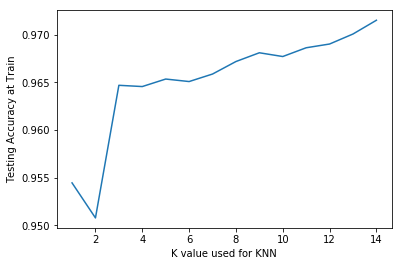

In [0]:
# plot the relationship between K and testing accuracy
plt.plot(k_range, cross_valid_scores)
plt.xlabel('K value used for KNN')
plt.ylabel('Testing Accuracy at Train')

Best k through model optimization is 9.

Fit model on training set

In [0]:
# fit the classifier for n_neighbors = 9
KNNclassifier = KNeighborsClassifier(n_neighbors = 9)
KNNclassifier.fit(scaledtrain_teamX, train_teamY)

KNN_train_accuracy = KNNclassifier.score(scaledtrain_teamX, train_teamY)
print('Accuracy on training set: {:.4f}'.format(KNN_train_accuracy ))

Accuracy on training set: 0.9747


Model evaluation on test

In [0]:
# get the predicted y of the model
KNN_y_pred = KNNclassifier.predict(scaledtest_teamX)

KNN_result = pd.DataFrame(confusion_matrix(test_teamY, KNN_y_pred),
                             index=KNNclassifier.classes_, columns=KNNclassifier.classes_)
print("Confusion Matrix:")
print(KNN_result)
KNN_result1 = classification_report(test_teamY, KNN_y_pred)
print("Classification Report:",)
print (KNN_result1)
KNN_result2 = accuracy_score(test_teamY, KNN_y_pred)
print("Accuracy at holdout:", KNN_result2)  
KNN_precision = precision_score(test_teamY, KNN_y_pred)
print("Precision at holdout:", KNN_precision)
KNN_recall = recall_score(test_teamY, KNN_y_pred)
print("Recall at holdout:", KNN_recall)

Confusion Matrix:
      0     1
0  1573    60
1    47  1586
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1633
           1       0.96      0.97      0.97      1633

    accuracy                           0.97      3266
   macro avg       0.97      0.97      0.97      3266
weighted avg       0.97      0.97      0.97      3266

Accuracy at holdout: 0.9672382118799755
Precision at holdout: 0.9635479951397327
Recall at holdout: 0.9712186160440907


**Observations**:
Though KNN classifier performs better in training and test better than NB classifier as it has higher accuracy, precision and recall. However, KNN classifier does not perform as well as Logistic in all of the areas. 

### Implement Random Forest classifier

Random Forest classifier will be optimized using GridSearch (with 5 k-folds) to determine optimal values for max features (number of features to be considered when looking for best split), minimum samples leaf (minimum proportion of samples to be at a leaf node) and maximum depth of the tree. 

In [0]:
# Initialize the Kfold cross validation
skfold = KFold(n_splits=5, shuffle=True, random_state=23)

# Initialize the set of parameters for exhaustive search and fit 
parameters = {'max_features': [2, 4, 5, 6, 8], 
              'min_samples_leaf': [1, 3, 4, 5, 7], 
              'max_depth': [5,7,8,9,10]}

# implement randomforest with 100 trees
rforestclassifier = RandomForestClassifier(n_estimators=100, 
                                           random_state=23, n_jobs=-1)

#GridSearch to find the optimal parameters for our example:
gcv = GridSearchCV(rforestclassifier, parameters, n_jobs=-1, cv=skfold, 
                   verbose=1)
gcv.fit(scaledtrain_teamX, train_teamY)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:  1.2min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=23, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=23,
                                              verbose=0, warm_start=False),
         

In [0]:
print('Best parameters:', gcv.best_params_) 
print('Accuracy at train:',gcv.best_score_)

Best parameters: {'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 4}
Accuracy at train: 0.9744094488188977


Train random forest model using best parameters

In [0]:
gcv = RandomForestClassifier(n_estimators=100, random_state=23, 
                            n_jobs=-1, max_depth=8, max_features=6, 
                            min_samples_leaf=4)
gcv.fit(scaledtrain_teamX, train_teamY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features=6, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [0]:
# get accuracy of model on training set
RF_train_accuracy = gcv.score(scaledtrain_teamX, train_teamY)
print('Accuracy on training set: {:.4f}'.format(RF_train_accuracy ))

Accuracy on training set: 0.9877


Evaluating trained Random Forest model on test

In [0]:
# get the predicted y of the model
rfc_y_pred = gcv.predict(scaledtest_teamX)

In [0]:
rfc_result = pd.DataFrame(confusion_matrix(test_teamY, rfc_y_pred),
                             index=gcv.classes_, columns=gcv.classes_)
print("Confusion Matrix:")
print(rfc_result)
rfc_result1 = classification_report(test_teamY, rfc_y_pred)
print("Classification Report:",)
print (rfc_result1)
rfc_result2 = accuracy_score(test_teamY, rfc_y_pred)
print("Accuracy for holdout:", rfc_result2) 
rfc_precision = precision_score(test_teamY, rfc_y_pred)
print("Precision at holdout:", rfc_precision)
rfc_recall = recall_score(test_teamY, rfc_y_pred)
print("Recall at holdout:", rfc_recall)

Confusion Matrix:
      0     1
0  1577    56
1    39  1594
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1633
           1       0.97      0.98      0.97      1633

    accuracy                           0.97      3266
   macro avg       0.97      0.97      0.97      3266
weighted avg       0.97      0.97      0.97      3266

Accuracy for holdout: 0.9709124311083894
Precision at holdout: 0.9660606060606061
Recall at holdout: 0.9761175750153093


In [0]:
names = Teams_df.columns
print ("Features sorted by its score:", 
       sorted(zip(map(lambda x: round(x, 5), 
                     gcv.feature_importances_), names), 
             reverse=True))

Features sorted by its score: [(0.67919, 'teamtowerkills'), (0.15774, 'kpm'), (0.1271, 'd'), (0.00824, 'minionkills'), (0.00742, 'elementals'), (0.0071, 'gdiffat15'), (0.00516, 'wcpm'), (0.00367, 'xpat10'), (0.00353, 'fbarontime'), (0.00086, 'ft')]


**Observations**:
1. Random forest picks teamtowerkills and kpm (kills per minutes) as top features, while the rest of features have relatively similar importance. 


2. Random Forest performs better than naive bayes, and KNN in terms of overall accuracy, precision and recall for winning and losing due to identifying lesser false positives and negatives. However, false positives identified are still higher than logistic due to lower true negatives than logistic. This caused random forest to have slightly lower overall accuracy than logistic

### Bagging on logistic, KNN, and Decision Tree

Bagging stands for bootstrap aggregation. One way to reduce the variance of an estimate is to average together multiple estimates. For example, we can train $M$ different trees $f_m$ on different subsets of the data (chosen randomly with replacement) and compute the ensemble:
\begin{equation}
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
\end{equation}

Bagging uses bootstrap sampling to obtain the data subsets for training the base learners. For aggregating the outputs of base learners, bagging uses voting for classification and averaging for regression.

In [0]:
# Tune decision tree using training set

# Initialize the 5 Kfold cross validation
skfold = KFold(n_splits=5, shuffle=True, random_state=23)

# Initialize the set of parameters for exhaustive search and fit 
parameters = {'max_features': [2, 4, 5, 6, 8], 
              'min_samples_leaf': [1, 3, 4, 5, 7], 
              'max_depth': [5,7,8,9,10]}

# implement Decision Tree
DT = DecisionTreeClassifier(random_state=23)

#GridSearch to find the optimal parameters for our example:
DT_search = GridSearchCV(DT, parameters, n_jobs=-1, cv=skfold, 
                   verbose=1)
DT_search.fit(scaledtrain_teamX, train_teamY)

Fitting 5 folds for each of 125 candidates, totalling 625 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 625 out of 625 | elapsed:    4.8s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=23, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=23,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 7, 8, 9, 10],
                        

In [0]:
print('Best parameters:', DT_search.best_params_) 
print('Accuracy at train:',DT_search.best_score_)

Best parameters: {'max_depth': 5, 'max_features': 8, 'min_samples_leaf': 7}
Accuracy at train: 0.9694225721784777


Train decision tree with best parameters

In [0]:
DT = DecisionTreeClassifier(random_state=23, 
                            max_depth=5, max_features=8, 
                            min_samples_leaf=7)
DT.fit(scaledtrain_teamX, train_teamY)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=23, splitter='best')

Try fit bagging on logistic, tuned KNN classifier, and tuned Decision Tree on training set

In [0]:
clf1 = logreg
clf2 = KNNclassifier  
clf3 = DT

bagging1 = BaggingClassifier(base_estimator=clf1, 
                             n_estimators=100, max_samples=0.7, 
                             max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, 
                             n_estimators=100, max_samples=0.7, 
                             max_features=0.8)
bagging3 = BaggingClassifier(base_estimator=clf3, 
                             n_estimators=100, max_samples=0.7, 
                             max_features=0.8)

In [0]:
# conduct 5-fold cross validation on bagging

label = ['Logistic', 'K-NN', 'Decision Tree', 
         'Bagging Logistic','Bagging K-NN', 'Bagging Tree']
clf_list = [clf1, clf2, clf3, bagging1, bagging2, bagging3]

for clf, label in zip(clf_list, label):        
    scores = cross_val_score(clf, np.array(scaledtrain_teamX), 
                             np.array(train_teamY), cv=5, 
                             scoring='accuracy')
    print ("Accuracy for train:", scores.mean(), scores.std(), label)

Accuracy for train: 0.9784776902887138 0.0024691453703709855 Logistic
Accuracy for train: 0.96745406824147 0.003950109433934996 K-NN
Accuracy for train: 0.9658792650918635 0.0026246719160105013 Decision Tree
Accuracy for train: 0.9770341207349083 0.002383976656769668 Bagging Logistic
Accuracy for train: 0.970734908136483 0.00338674223111916 Bagging K-NN
Accuracy for train: 0.9725721784776903 0.0012723569179570364 Bagging Tree


Bagging does improve KNN and decision tree model but still performs not as good as normal Logistic

Model evaluation of bagging KNN on train and test

In [0]:
# model accuracy on training set
bagging2.fit(scaledtrain_teamX, train_teamY)
bKNN_train_accuracy = bagging2.score(scaledtrain_teamX, train_teamY)
print('Accuracy on training set: {:.4f}'.format(bKNN_train_accuracy ))

Accuracy on training set: 0.9774


In [0]:
# result of Bagging KNN on test
bKNN_y_pred = bagging2.predict(scaledtest_teamX)

bKNN_result = pd.DataFrame(confusion_matrix(test_teamY, bKNN_y_pred), 
                           index=bagging2.classes_,
                          columns=bagging2.classes_)
print("Confusion Matrix:")
print(bKNN_result)
bKNN_result1 = classification_report(test_teamY, bKNN_y_pred)
print("Classification Report:",)
print (bKNN_result1)
bKNN_result2 = accuracy_score(test_teamY, bKNN_y_pred)
print("Accuracy for holdout:", bKNN_result2) 
bKNN_precision = precision_score(test_teamY, bKNN_y_pred)
print("Precision at holdout:", bKNN_precision)
bKNN_recall = recall_score(test_teamY, bKNN_y_pred)
print("Recall at holdout:", bKNN_recall)

Confusion Matrix:
      0     1
0  1572    61
1    37  1596
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1633
           1       0.96      0.98      0.97      1633

    accuracy                           0.97      3266
   macro avg       0.97      0.97      0.97      3266
weighted avg       0.97      0.97      0.97      3266

Accuracy for holdout: 0.969993876301286
Precision at holdout: 0.9631864815932408
Recall at holdout: 0.977342314758114


Model evaluation of bagging decision tree on train and test

In [0]:
# model accuracy on training set
bagging3.fit(scaledtrain_teamX, train_teamY)
bdtree_train_accuracy = bagging3.score(scaledtrain_teamX, train_teamY)
print('Accuracy on training set: {:.4f}'.format(bdtree_train_accuracy ))

Accuracy on training set: 0.9781


In [0]:
# validate train model on test set

bdtree_y_pred = bagging3.predict(scaledtest_teamX)

bdtree_result = pd.DataFrame(confusion_matrix(test_teamY, bdtree_y_pred), 
                             index=bagging3.classes_,
                          columns=bagging3.classes_)
print("Confusion Matrix:")
print(bdtree_result)
bdtree_result1 = classification_report(test_teamY, bdtree_y_pred)
print("Classification Report:",)
print (bdtree_result1)
bdtree_result2 = accuracy_score(test_teamY, bdtree_y_pred)
print("Accuracy for holdout:", bdtree_result2) 
bdtree_precision = precision_score(test_teamY, bdtree_y_pred)
print("Precision at holdout:", bdtree_precision)
bdtree_recall = recall_score(test_teamY, bdtree_y_pred)
print("Recall at holdout:", bdtree_recall)

Confusion Matrix:
      0     1
0  1572    61
1    28  1605
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1633
           1       0.96      0.98      0.97      1633

    accuracy                           0.97      3266
   macro avg       0.97      0.97      0.97      3266
weighted avg       0.97      0.97      0.97      3266

Accuracy for holdout: 0.9727495407225965
Precision at holdout: 0.9633853541416567
Recall at holdout: 0.9828536436007348


**Observations**:

In holdout, Bagging KNN generates higher recall (due to lower false negatives) (but high false positives than KNN without bagging) while bagging Decision Tree generates higher true positives and lesser false negatives than other models (higher recall). Yet, both overall accuracies are still lower than Logistic due to higher false positives (lower precision)

### Adaboosting classifier

We will now be using adaboost (adaptive boosting)classification on base learner, which is decision tree 

Classifier will be tuned in 5-folds using n_estimator and learning rate: 
- n_estimators refer to maximum number of estimators at which boosting is terminated
- learning rate refers how much the contribution of each classifiers is shrinked by

In [0]:
ada=AdaBoostClassifier()
ada_search_grid={'n_estimators':[500,1000,1500,2000],
                 'learning_rate':[.001,0.01,.1]}

ada_search=GridSearchCV(estimator=ada,
                        param_grid=ada_search_grid, 
                        scoring='accuracy',n_jobs=-1,cv=5)

In [0]:
ada_search.fit(scaledtrain_teamX, train_teamY)
print(ada_search.best_params_)
print('Accuracy for train:', ada_search.best_score_)

{'learning_rate': 0.01, 'n_estimators': 2000}
Accuracy for train: 0.9753280839895013


In [0]:
# train model with best parameters
ada_best = AdaBoostClassifier(n_estimators=2000, 
                              learning_rate = 0.01, random_state=23)
ada_best.fit(scaledtrain_teamX, train_teamY)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=2000, random_state=23)

In [0]:
# model accuracy on training set

ada_train_accuracy = ada_best.score(scaledtrain_teamX, train_teamY)
print('Accuracy on training set: {:.4f}'.format(ada_train_accuracy ))

Accuracy on training set: 0.9766


Use trained model for validation on holdout

In [0]:
ada_y_pred = ada_best.predict(scaledtest_teamX)

ada_result = pd.DataFrame(confusion_matrix(test_teamY, ada_y_pred), index=ada_best.classes_,
                          columns=ada_best.classes_)
print("Confusion Matrix:")
print(ada_result)
ada_result1 = classification_report(test_teamY, ada_y_pred)
print("Classification Report:",)
print (ada_result1)
ada_result2 = accuracy_score(test_teamY, ada_y_pred)
print("Accuracy for holdout:", ada_result2) 
ada_precision = precision_score(test_teamY, ada_y_pred)
print("Precision at holdout:", ada_precision)
ada_recall = recall_score(test_teamY, ada_y_pred)
print("Recall at holdout:", ada_recall)

Confusion Matrix:
      0     1
0  1580    53
1    32  1601
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1633
           1       0.97      0.98      0.97      1633

    accuracy                           0.97      3266
   macro avg       0.97      0.97      0.97      3266
weighted avg       0.97      0.97      0.97      3266

Accuracy for holdout: 0.9739742804654011
Precision at holdout: 0.967956469165659
Recall at holdout: 0.9804041641151255


**Observation**:

Adaboosting Classifier performs better in precision than other models due to lesser false positives (only higher than Logistic). It also has high recall (just lower than bagging decision tree) due to low false negatives.

Overall accuracy is higher than other models but lower than Logistic. 
However, boosting has proved to achieve higher accuracy than bagging for Decision Tree (higher true negatives and lower false positives), reducing bias in Decision Tree

### Implement Multi Layer Perceptron

Multilayer perceptron (MLP) is a supervised neural network model. It is composed of more than one perceptron. They are composed of an input layer to receive the signal, an output layer that makes a decision or prediction about the input, and in between those two, an arbitrary number of hidden layers that are the true computational engine of the MLP. MLPs with one hidden layer are capable of approximating any continuous function.

- hidden_layer_sizes : This parameter allows us to set the number of layers and the number of nodes we wish to have in the Neural Network Classifier. Each element in the tuple represents the number of nodes at the ith position where i is the index of the tuple. Thus the length of tuple denotes the total number of hidden layers in the network.
- max_iter: It denotes the number of epochs (cycle through full dataset).
- activation: The activation function for the hidden layers.
- alpha: L2 penalty (regularization term) parameter
- solver: This parameter specifies the algorithm for weight optimization across the nodes.
- random_state: The parameter allows to set a seed for reproducing the same results

In [0]:
#Importing MLPClassifier
from sklearn.neural_network import MLPClassifier

In [0]:
# tune multi layer perceptron using training set

# tune parameters with 5 fold cross validation

parameters = {'solver': ['lbfgs'], 
              'activation': ['logistic','relu'],
              'max_iter': [500, 550, 600, 700, 800], 
              'alpha': 10.0 ** -np.arange(1, 5), 
              'hidden_layer_sizes':np.arange(6, 10)}

mlp= GridSearchCV(MLPClassifier(random_state=23), 
                  parameters, n_jobs=-1, cv=5)

mlp.fit(scaledtrain_teamX, train_teamY)
print(mlp.score(scaledtrain_teamX, train_teamY))
print(mlp.best_params_)

0.9805774278215224
{'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': 7, 'max_iter': 500, 'solver': 'lbfgs'}


In [0]:
# train momodel with best params
mlp = MLPClassifier(solver='lbfgs', max_iter=500, 
                    alpha=0.1, hidden_layer_sizes=7,
                   random_state=23)
mlp.fit(scaledtrain_teamX, train_teamY)

mlp_score = np.mean(train_teamY == mlp.predict(scaledtrain_teamX))
print('Accuracy for train:', mlp_score)

Accuracy for train: 0.9805774278215224


In [0]:
# validating model in holdout

mlp_y_pred =  mlp.predict(scaledtest_teamX)

mlp_result = pd.DataFrame(confusion_matrix(test_teamY, mlp_y_pred), 
                          index=mlp.classes_,
                           columns=mlp.classes_)
print("Confusion Matrix:")
print(mlp_result)
mlp_result1 = classification_report(test_teamY, mlp_y_pred)
print("Classification Report:",)
print (mlp_result1)
mlp_result2 = accuracy_score(test_teamY, mlp_y_pred)
print("Accuracy for holdout:", mlp_result2) 
mlp_precision = precision_score(test_teamY, mlp_y_pred)
print("Precision at holdout:", mlp_precision)
mlp_recall = recall_score(test_teamY, mlp_y_pred)
print("Recall at holdout:", mlp_recall)

Confusion Matrix:
      0     1
0  1585    48
1    38  1595
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1633
           1       0.97      0.98      0.97      1633

    accuracy                           0.97      3266
   macro avg       0.97      0.97      0.97      3266
weighted avg       0.97      0.97      0.97      3266

Accuracy for holdout: 0.9736680955296999
Precision at holdout: 0.970785149117468
Recall at holdout: 0.9767299448867116


**Observations**:

Multi layer perceptron has the second highest accuracy (below Adaboost) among all individual models. While it has second highest precision after Logistic, it is also the 4th highest in recall after Adaboost, Bagging Decision Tree, and Bagging KNN.
Overall, its performance is well-balanced in all areas. 

### Ensemble Voting Classifier

The EnsembleVoteClassifier is a meta-classifier for combining similar or conceptually different machine learning classifiers for classification via majority or plurality voting. (For simplicity, we will refer to both majority and plurality voting as majority voting.)

The EnsembleVoteClassifier implements "hard" and "soft" voting. In hard voting, we predict the final class label as the class label that has been predicted most frequently by the classification models. In soft voting, we predict the class labels by averaging the class-probabilities (only recommended if the classifiers are well-calibrated).

In [0]:
# using pre-fitted classifiers
# models used in this ensemble (which produces the best precision): 
# logreg, random forest, adaboost, multilayer perceptron

clf1 = logreg
clf2 = gcv  #random forest (grid search)
clf3 = ada_best #adaboost
clf4 = mlp # multi layer perceptron

In [0]:
# By setting refit=False, 
# the EnsembleVoteClassifier will not re-fit these classifers to save computational time

eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3, clf4], 
                              weights=[1,1,1,1], 
                              refit=False)

eclf.fit(scaledtrain_teamX, train_teamY)

Voting_score = np.mean(train_teamY == eclf.predict(scaledtrain_teamX))
print('accuracy for train:', Voting_score)

accuracy for train: 0.981496062992126


Model validation for ensemble voting classifier

In [0]:
eclf_y_pred = eclf.predict(scaledtest_teamX)

eclf_result = pd.DataFrame(confusion_matrix(test_teamY, eclf_y_pred), index=eclf.classes_,
                           columns=eclf.classes_)
print("Confusion Matrix:")
print(eclf_result)
eclf_result1 = classification_report(test_teamY, eclf_y_pred)
print("Classification Report:",)
print (eclf_result1)
eclf_result2 = accuracy_score(test_teamY, eclf_y_pred)
print("Accuracy for holdout:", eclf_result2) 
eclf_precision = precision_score(test_teamY, eclf_y_pred)
print("Precision at holdout:", eclf_precision)
eclf_recall = recall_score(test_teamY, eclf_y_pred)
print("Recall at holdout:", eclf_recall)

Confusion Matrix:
      0     1
0  1592    41
1    38  1595
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1633
           1       0.97      0.98      0.98      1633

    accuracy                           0.98      3266
   macro avg       0.98      0.98      0.98      3266
weighted avg       0.98      0.98      0.98      3266

Accuracy for holdout: 0.975811390079608
Precision at holdout: 0.9749388753056235
Recall at holdout: 0.9767299448867116


**Observations**:
Ensemble voting classifiers performs better in the holdout than all individual models. 
Ensemble voting performs better than Logistic in generating higher winning predictions and lower false negatives for winning. 

### Implement Stacked Classsification and cross validation

Stacking is an ensemble learning technique to combine multiple classification models via a meta-classifier. The StackingCVClassifier extends the standard stacking algorithm (implemented as StackingClassifier) using cross-validation to prepare the input data for the level-2 classifier.

In the standard stacking procedure, the first-level classifiers are fit to the same training set that is used prepare the inputs for the second-level classifier, which may lead to overfitting. The StackingCVClassifier, however, uses the concept of cross-validation: the dataset is split into k folds, and in k successive rounds, k-1 folds are used to fit the first level classifier; in each round, the first-level classifiers are then applied to the remaining 1 subset that was not used for model fitting in each iteration. The resulting predictions are then stacked and provided -- as input data -- to the second-level classifier. After the training of the StackingCVClassifier, the first-level classifiers are fit to the entire dataset as illustrated in the figure below.

#### Stacked CV Classification and GridSearch

The stack allows tuning hyper parameters of the base and meta models. 3-fold cross-validation will be used for this model

Logistic as meta classifier with random forest, adaboost and multi layer perceptron as base learners

In [0]:
RANDOM_SEED = 23
# models used in this ensemble (which produces the best precision): 
# logreg, random forest, adaboost, multilayer perceptron

lr = logreg #logistic regression will be used as meta classifier
clf1 = gcv  #random forest (grid search)
clf2 = ada_best #boosting Decision Tree
clf3 = mlp #multi-layer perceptron

sclf = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf], 
                      ['Random Forest',
                       'Boosting Decision Tree',
                       'Multi Layer Perceptron',
                       'Stacking Classifier']):

    scores = cross_val_score(clf, scaledtrain_teamX, train_teamY, 
                                              cv=3, scoring='accuracy')
    print("Accuracy at train: %0.3f (+/- %0.3f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy at train: 0.973 (+/- 0.002) [Random Forest]
Accuracy at train: 0.974 (+/- 0.001) [Boosting Decision Tree]
Accuracy at train: 0.972 (+/- 0.004) [Multi Layer Perceptron]
Accuracy at train: 0.974 (+/- 0.000) [Stacking Classifier]


Model validation on training set

In [0]:
sclf.fit(scaledtrain_teamX, train_teamY)
sclf_accuracy = np.mean(train_teamY == sclf.predict(scaledtrain_teamX))
print('accuracy at train:', sclf_accuracy)

accuracy at train: 0.9822834645669292


Model validation on test

In [0]:
sclf_y_pred = sclf.predict(scaledtest_teamX)

sclf_result = pd.DataFrame(confusion_matrix(test_teamY, sclf_y_pred))
print("Confusion Matrix:")
print(sclf_result)
sclf_result1 = classification_report(test_teamY, sclf_y_pred)
print("Classification Report:",)
print (sclf_result1)
sclf_result2 = accuracy_score(test_teamY, sclf_y_pred)
print("Accuracy at holdout:", sclf_result2)
sclf_precision = precision_score(test_teamY, sclf_y_pred)
print("Precision at holdout:", sclf_precision)
sclf_recall = recall_score(test_teamY, sclf_y_pred)
print("Recall at holdout:", sclf_recall)

Confusion Matrix:
      0     1
0  1578    55
1    33  1600
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1633
           1       0.97      0.98      0.97      1633

    accuracy                           0.97      3266
   macro avg       0.97      0.97      0.97      3266
weighted avg       0.97      0.97      0.97      3266

Accuracy at holdout: 0.9730557256582976
Precision at holdout: 0.9667673716012085
Recall at holdout: 0.9797917942437232


**Observations**:
Although overall accuracy in holdout is lower than ensemble voting, the precision for winning (1) is higher than ensemble voting due to lower false negative.  While ensemble voting better predicts true positives, ensemble stacking predicts more false positives (ensemble voting holds the lowest false positives (41)). Ensemble staking ensembles preform better than most models except Logistic, Adaboost and Multi Layer Perceptron.

#### Stacking with Multi Layer Perceptron as Meta-classifier

In [0]:
RANDOM_SEED = 23
# models used in this ensemble (which produces the best precision): 
# logreg, random forest, adaboost, multilayer perceptron

lr = mlp #mlp will be used as meta classifier
clf1 = logreg
clf2 = gcv  #random forest (grid search)
clf3 = ada_best #boosting Decision Tree

sclf2 = StackingCVClassifier(classifiers=[clf1, clf2, clf3],
                            meta_classifier=lr,
                            random_state=RANDOM_SEED)

print('3-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, sclf2], 
                      ['Logistic',
                       'Random Forest',
                       'Boosting Decision Tree',
                       'Stacking Classifier']):

    scores = cross_val_score(clf, scaledtrain_teamX, train_teamY, 
                                              cv=3, scoring='accuracy')
    print("Accuracy at train: %0.3f (+/- %0.3f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy at train: 0.978 (+/- 0.001) [Logistic]
Accuracy at train: 0.973 (+/- 0.002) [Random Forest]
Accuracy at train: 0.974 (+/- 0.001) [Boosting Decision Tree]
Accuracy at train: 0.978 (+/- 0.001) [Stacking Classifier]


In [0]:
sclf2.fit(scaledtrain_teamX, train_teamY)
sclf2_accuracy = np.mean(train_teamY == sclf2.predict(scaledtrain_teamX))
print('accuracy at train:', sclf2_accuracy)

accuracy at train: 0.9796587926509186


In [0]:
sclf2_y_pred = sclf2.predict(scaledtest_teamX)

sclf2_result = pd.DataFrame(confusion_matrix(test_teamY, sclf2_y_pred))
print("Confusion Matrix:")
print(sclf2_result)
sclf2_result1 = classification_report(test_teamY, sclf2_y_pred)
print("Classification Report:",)
print (sclf2_result1)
sclf2_result2 = accuracy_score(test_teamY, sclf2_y_pred)
print("Accuracy at holdout:", sclf2_result2)
sclf2_precision = precision_score(test_teamY, sclf2_y_pred)
print("Precision at holdout:", sclf2_precision)
sclf2_recall = recall_score(test_teamY, sclf2_y_pred)
print("Recall at holdout:", sclf2_recall)

Confusion Matrix:
      0     1
0  1593    40
1    41  1592
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1633
           1       0.98      0.97      0.98      1633

    accuracy                           0.98      3266
   macro avg       0.98      0.98      0.98      3266
weighted avg       0.98      0.98      0.98      3266

Accuracy at holdout: 0.9751990202082057
Precision at holdout: 0.9754901960784313
Recall at holdout: 0.9748928352725046


**Observations**: 
Overall accuracy is higher when we have multi layer perceptron as meta classifier as compared to previous stacking (when logistic is the meta classifier) as logistic is a better base learner. 
This Stacking Ensemble has the highest precision with the lowest false postives and highest false negatives. 
However, false negatives is higher than other ensembles but that is not our main concern. So, this Stacking performs the best and stable when compared to accuracy in training. 

### Summary of overall accuracy, precision and recall of all models

In [0]:
# accuracy at train

accuracy_train = pd.DataFrame.from_dict({'Logistic'    :logreg_train_accuracy, 
                        'Naive Bayes'                  :NB_train_accuracy,
                        'KNN'                          :KNN_train_accuracy,
                        'Random Forest'                :RF_train_accuracy,
                        'Bagging KNN'                  :bKNN_train_accuracy,
                        'Bagging Decision Tree'        :bdtree_train_accuracy,
                        'Adaboost Classifer'           :ada_train_accuracy,
                        'Multi Layer Perceptron'       : mlp_score,
                        'EnsembleVoting'               :Voting_score,
                        'EnsembleStacking (logreg)'     :sclf_accuracy,
                        'EnsembleStacking (MLP)'       :sclf2_accuracy}, 
                                  orient='index',columns=['Accuracy_train'])
accuracy_train = accuracy_train.sort_values(by='Accuracy_train', ascending=False)
accuracy_train

,Accuracy_train
Random Forest,0.987664
EnsembleStacking (logreg),0.982283
EnsembleVoting,0.981496
Multi Layer Perceptron,0.980577
EnsembleStacking (MLP),0.979659
Logistic,0.978740
Bagging Decision Tree,0.978084
Bagging KNN,0.977428
Adaboost Classifer,0.976640
KNN,0.974672


In [0]:
# accuracy at holdout

accuracy_test = pd.DataFrame.from_dict({'Logistic'    :logreg_result2, 
                        'Naive Bayes'                 :NB_result2,
                        'KNN'                         :KNN_result2,
                        'Random Forest'               :rfc_result2,
                        'Bagging KNN'                 :bKNN_result2,
                        'Bagging Decision Tree'       :bdtree_result2,
                        'Adaboost Classifer'           :ada_result2,
                        'Multi Layer Perceptron'       :mlp_result2,
                        'Ensemble Voting'              :eclf_result2,
                        'EnsembleStacking (logreg)'     :sclf_result2,
                        'EnsembleStacking (MLP)'       :sclf2_result2}, 
                                  orient='index',columns=['Accuracy_holdout'])
accuracy_test = accuracy_test.sort_values(by='Accuracy_holdout', ascending=False)
accuracy_test

,Accuracy_holdout
Ensemble Voting,0.975811
EnsembleStacking (MLP),0.975199
Logistic,0.974587
Adaboost Classifer,0.973974
Multi Layer Perceptron,0.973668
EnsembleStacking (logreg),0.973056
Bagging Decision Tree,0.972750
Random Forest,0.970912
Bagging KNN,0.969994
KNN,0.967238


Comparing accuracy in train and holdout, it seems like Ensemble Staking (MLP as meta classifier) performs more stable than Ensemble Voting. Logistic is stable too but its accuracy is lower than Ensemble Staking (MLP). Random Forest and Ensemble Stacking (logistic) are overfitting in training. 

In [0]:
# precision at holdout

precision = pd.DataFrame.from_dict({'Logistic'          :logreg_precision, 
                        'Naive Bayes'                   :NB_precision,
                        'KNN'                           :KNN_precision,
                        'Random Forest'                 :rfc_precision,
                        'Bagging KNN'                   :bKNN_precision,
                        'Bagging Decision Tree'         :bdtree_precision,
                        'Adaboost Classifer'            :ada_precision,
                        'Multi Layer Perceptron'        : mlp_precision,
                        'Ensemble Voting'               :eclf_precision,
                        'Ensemble Stacking (logreg)'    :sclf_precision,
                        'Ensemble Stacking (MLP)'       :sclf2_precision}, 
                                  orient='index',columns=['Precision'])
precision = precision.sort_values(by='Precision', ascending=False)
precision

,Precision
Ensemble Stacking (MLP),0.975490
Ensemble Voting,0.974939
Logistic,0.973716
Multi Layer Perceptron,0.970785
Adaboost Classifer,0.967956
Ensemble Stacking (logreg),0.966767
Random Forest,0.966061
KNN,0.963548
Bagging Decision Tree,0.963385
Bagging KNN,0.963186


In [0]:
# recall at holdout

recall = pd.DataFrame.from_dict({'Logistic'         :logreg_recall, 
                        'Naive Bayes'               :NB_recall,
                        'KNN'                       :KNN_recall,
                        'Random Forest'             :rfc_recall,
                        'Bagging KNN'               :bKNN_recall,
                        'Bagging Decision Tree'     :bdtree_recall,
                        'Adaboost Classifer'        :ada_recall,
                        'Multi Layer Perceptron'    : mlp_recall,
                        'Ensemble Voting'           :eclf_recall,
                        'Ensemble Stacking (logreg)':sclf_recall,
                        'Ensemble Stacking (MLP)'   :sclf2_recall}, 
                                  orient='index',columns=['Recall'])
recall = recall.sort_values(by='Recall', ascending=False)
recall

,Recall
Bagging Decision Tree,0.982854
Adaboost Classifer,0.980404
Ensemble Stacking (logreg),0.979792
Bagging KNN,0.977342
Multi Layer Perceptron,0.976730
Ensemble Voting,0.976730
Random Forest,0.976118
Logistic,0.975505
Ensemble Stacking (MLP),0.974893
KNN,0.971219


## Selecting the best model

Overall, Stacking Ensemble (base learners: logistic model, random forest model, and adaboost model; meta classifier: multilayer perceptron model) performs the best, especially in precision (lowest false positives)

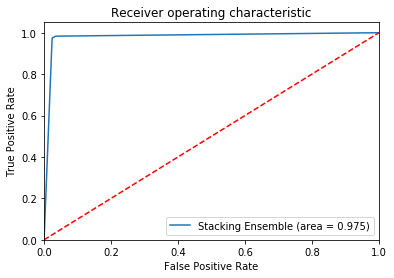

In [0]:
# generate its ROC curve

sclf2_roc_auc = roc_auc_score(test_teamY, sclf2.predict(scaledtest_teamX))
fpr, tpr, thresholds = roc_curve(test_teamY,sclf2.predict_proba(scaledtest_teamX)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Stacking Ensemble (area = %0.3f)' % sclf2_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

ROC curve highlights that Stacking Ensemble produces less false positives and higher true positives

## Save normalizing and models using pickle

Models are saved to be used in calculator


Dummy new data to test on pickle:

In [0]:
link = 'https://drive.google.com/open?id=17uwHLjIfDWV-DJqZSNVlAi65leF3VeSL'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Calculator_features.xlsx')  
calculator_features = pd.read_excel('Calculator_features.xlsx')

calculator_features

### Pickle normalization process

In [0]:
# using the scale in training set
# Save scaler to file in the current working directory
# link = 'https://drive.google.com/open?id=1bwcZ4-YqhUlexAolQ0e9GxvKHc0HtSCg'
# fluff, id = link.split('=')
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('scaler.pkl') 

scaler_filename = "scaler.pkl"
#with open(scaler_filename, 'wb') as scalerfile:
#    pickle.dump(scaler, scalerfile)
    
# Load from file
with open(scaler_filename, 'rb') as scalerfile:
    pickle_scaler = pickle.load(scalerfile)


In [0]:
scaled_calculatorfeatures = pickle_scaler.transform(calculator_features)
scaled_calculatorfeatures

array([[ -0.24534682,  -0.69661777,   0.99398137,  -0.30739642,
         -1.5532756 ,  -0.57916875,  -1.1175161 ,  -4.21004401,
        -22.67418681,   8.04854443]])

### Pickle logistic regression and run prediction

In [0]:
# Save NBclassifier to file in the current working directory
logit_filename = "Logistic.pkl"
#with open(logit_filename, 'wb') as logitfile:
#    pickle.dump(logreg, logitfile)
    
# Load from file
with open(logit_filename, 'rb') as logitfile:
    pickle_logitmodel = pickle.load(logitfile)

In [0]:
# predict probability of target values
logit_Ypredictprob = pickle_logitmodel.predict_proba(scaled_calculatorfeatures)[:,1]
print('Probabilities of winning:', logit_Ypredictprob)

Probabilities of winning: [3.13179592e-06]


### Pickle Naive Bayes classifier and run prediction

In [0]:
# Save NBclassifier to file in the current working directory
NB_filename = "NB_model.pkl"
#with open(NB_filename, 'wb') as NBfile:
#    pickle.dump(NBclassifier, NBfile)
    
# Load from file
with open(NB_filename, 'rb') as NBfile:
    pickle_NBmodel = pickle.load(NBfile)

In [0]:
# Calculate the accuracy score of NB and predict target values
NB_Ypredictprob = pickle_NBmodel.predict_proba(scaled_calculatorfeatures)[:,1]
print('Probabilities of winning:', NB_Ypredictprob)

Probabilities of winning: [1.06427743e-19]


### Pickle Bagging KNN classifier and run prediction

In [0]:
# Save KNNclassifier to file in the current working directory
KNN_filename = "KNN_model.pkl"
#with open(KNN_filename, 'wb') as KNNfile:
#    pickle.dump (bagging2, KNNfile)
    
# Load from file
with open(KNN_filename, 'rb') as KNNfile:
    pickle_KNNmodel = pickle.load(KNNfile)

In [0]:
# Calculate the accuracy score of KNN and predict target values
KNN_Ypredictprob = pickle_KNNmodel.predict_proba(scaled_calculatorfeatures)[:,1]
print('Probabilities of winning:', KNN_Ypredictprob)

Probabilities of winning: [0.42777778]


### Pickle Random Forest classifier and run prediction

In [0]:
# Save RFclassifier to file in the current working directory
RFC_filename = "RFC_model.pkl"
#with open(RFC_filename, 'wb') as RFCfile:
#     pickle.dump(gcv, RFCfile)
    
# Load from file
with open(RFC_filename, 'rb') as RFCfile:
    pickle_RFCmodel = pickle.load(RFCfile)

In [0]:
# Calculate the accuracy score of Random Forest and predict target values
RFC_Ypredictprob = pickle_RFCmodel.predict_proba(scaled_calculatorfeatures)[:,1]
print('Probabilities of winning:', RFC_Ypredictprob)

Probabilities of winning: [0.01100292]


### Pickle bagging Decision Tree and run prediction

In [0]:
# Save bagging DT classifier to file in the current working directory
bdt_filename = "bDecisionTree_model.pkl"
#with open(bdt_filename, 'wb') as bdtfile:
#    pickle.dump(bagging3, bdtfile)
    
# Load from file
with open(bdt_filename, 'rb') as bdtfile:
    pickle_bdt = pickle.load(bdtfile)

In [0]:
# Calculate the accuracy score of bagging Decision Tree and predict target values
bdt_Ypredictprob = pickle_bdt.predict_proba(scaled_calculatorfeatures)[:,1]
print('Probabilities of winning:', bdt_Ypredictprob)

Probabilities of winning: [0.04038268]


### Pickle Adaboost model and run prediction

In [0]:
# Save adaboost classifier to file in the current working directory
ada_filename = "adaboosting_model.pkl"
#with open(ada_filename, 'wb') as adafile:
#    pickle.dump(ada_best, adafile)
    
# Load from file
with open(ada_filename, 'rb') as adafile:
    pickle_ada = pickle.load(adafile)

In [0]:
# Calculate the accuracy score of adaboost and predict target values
ada_Ypredictprob = pickle_ada.predict_proba(scaled_calculatorfeatures)[:,1]
print('Probabilities of winning:', ada_Ypredictprob)

Probabilities of winning: [0.44611855]


### Pickle Multi Layer Perceptron

In [0]:
# Save bagging DT classifier to file in the current working directory
mlp_filename = "mlp_model.pkl"
#with open(mlp_filename, 'wb') as mlpfile:
#    pickle.dump(mlp, mlpfile)
    
# Load from file
with open(mlp_filename, 'rb') as mlpfile:
    pickle_mlp = pickle.load(mlpfile)

In [0]:
# Calculate the accuracy score of bagging Decision Tree and predict target values
mlp_Ypredictprob = pickle_mlp.predict_proba(scaled_calculatorfeatures)[:,1]
print('Probabilities of winning:', mlp_Ypredictprob)

Probabilities of winning: [1.13269882e-16]


### Pickle Ensemble Voting Classifier and run prediction

In [0]:
# Save ensemble voting classifier to file in the current working directory
eclf_filename = "Ensemblevoting_model.pkl"
#with open(eclf_filename, 'wb') as eclffile:
#    pickle.dump(eclf, eclffile)
    
# Load from file
with open(eclf_filename, 'rb') as eclffile:
    pickle_eclf = pickle.load(eclffile)

In [0]:
# Calculate the accuracy score of Ensemble Voting and predict target values
eclf_Ypredictprob = pickle_eclf.predict_proba(scaled_calculatorfeatures)[:,1]
print('Probabilities of winning:', eclf_Ypredictprob)

Probabilities of winning: [0.11428115]


### Pickle Stacking Classifier (MLP)

In [0]:
# Save stacking classifier to file in the current working directory
sclf2_filename = "Stacking_model.pkl"
#with open(sclf2_filename, 'wb') as sclffile:
#    pickle.dump(sclf2, sclffile)
    
# Load from file
with open(sclf2_filename, 'rb') as sclffile:
    pickle_sclf2 = pickle.load(sclffile)

In [0]:
# Calculate the accuracy score of stacking and predict target values
sclf_Ypredictprob = pickle_sclf2.predict_proba(scaled_calculatorfeatures)[:,1]
print('Probabilities of winning:', sclf_Ypredictprob)

Probabilities of winning: [0.01536449]


### Get the best model's probability 

In [0]:
bestmodel_prob = float(sclf_Ypredictprob)
print("Average probability of all models is:", bestmodel_prob)

Average probability of all models is: 0.01536449179415549


## End-product development (calculator)

In [0]:
from tkinter import *
import pandas as pd
import pickle

In [0]:
class LOLcalculator:

    def __init__(self):
        # create a window
        window = Tk()
        window.title("League of Legends Match Calculator") #set title
        window.configure(background='black')
        window.geometry("1300x1200")

        # create time
        localtime  = time.asctime(time.localtime(time.time()))
        titlelabel = Label(window, font=("Helvetica", 24), text="LOL MATCH PREDICTION", 
                          fg="silver", bg='black').grid(row=0, column=1, sticky=W)
        timelabel  = Label(window, font=("Helvetica", 12), text=localtime, 
                          fg="silver", bg='black').grid(row=0, column=3, sticky=W)
        
        # create the input boxes
        dlabel     = Label(window, height=3,width=35, font=("Helvetica", 14), fg="white",bg="blue", 
                           text = "Total deaths (count)").grid(row=1, column=1, sticky=W)
        kpmlabel   = Label(window, height=3,width=35, font=("Helvetica", 14),fg="white",bg="blue",
                           text = "Kill rate per minute (0 to 2)").grid(row=2, column=1, sticky=W)
        ftlabel    = Label(window, height=3,width=35, font=("Helvetica", 14),fg="white",bg="blue",
                           text = "First tower destroyed (0 or 1)").grid(row=3, column=1, sticky=W)
        towerlabel = Label(window, height=3,width=35, font=("Helvetica", 14),fg="white",bg="blue",
                           text = "Total tower kills (count)").grid(row=4, column=1, sticky=W)
        baronlabel = Label(window, height=3,width=35, font=("Helvetica", 14),fg="white",bg="blue",
                           text = "Time baron killed (mins)").grid(row=5, column=1, sticky=W)
        elemlabel  = Label(window, height=3,width=35, font=("Helvetica", 14),fg="white",bg="blue",
                           text = "Total elementals killed (count)").grid(row=6, column=1, sticky=W)
        wcpmlabel  = Label(window, height=3,width=35, font=("Helvetica", 14),fg="white",bg="blue",
                           text = "Total wards cleared per min (0 to 5)").grid(row=7, column=1, sticky=W)
        minionlabel= Label(window, height=3,width=35, font=("Helvetica", 14), fg="white",bg="blue",
                           text = "Total minions killed (team)").grid(row=8, column=1, sticky=W)
        xpat10label= Label(window, height=3,width=35, font=("Helvetica", 14),fg="white",bg="blue",
                           text = "Xp gained at 10 minutes (team)").grid(row=9, column=1, sticky=W)
        gold15label= Label(window, height=3,width=35, font=("Helvetica", 14),fg="white",bg="blue",
                           text = "Gold difference at 15 min (-ve/+ve)").grid(row=10, column=1, sticky=W)
        problabel  = Label(window, height=3,width=35, font=("Helvetica", 14),fg="white",bg="maroon",
                           text = "Probability of team winning the match (>0.5)").grid(row=11, column=1, sticky=W)
        
        # functions to take inputs
        self.d = DoubleVar()
        Scale(window, orient=HORIZONTAL, length=500, width=25, sliderlength=10,
             from_=0,to=50, tickinterval=5, variable=self.d).grid(row = 1, column = 2)
        
        self.kpm = DoubleVar()
        Scale(window, orient=HORIZONTAL, length=500, width=25, sliderlength=10,
             from_=0.00,to=2.00, tickinterval=0.50, digits=3, resolution=0.01,
              variable=self.kpm).grid(row = 2, column = 2)
        
        self.ft = DoubleVar()
        Scale(window, orient=HORIZONTAL, length=500, width=25, sliderlength=10,
             from_=0,to=1, tickinterval=1, variable=self.ft).grid(row = 3, column = 2)
        
        self.teamtowerkills = DoubleVar()
        Scale(window, orient=HORIZONTAL, length=500, width=25, sliderlength=10,
             from_=0,to=11, tickinterval=1, variable=self.teamtowerkills).grid(row = 4, column = 2)
        
        self.fbarontime = DoubleVar() 
        Scale(window, orient=HORIZONTAL, length=500, width=25, sliderlength=10,
             from_=19.00,to=50.00, tickinterval=5.00, digits=3, resolution=0.01,
              variable=self.fbarontime).grid(row = 5, column = 2)
        
        self.elementals = DoubleVar()
        Scale(window, orient=HORIZONTAL, length=500, width=25, sliderlength=10,
             from_=0,to=6, tickinterval=1, variable=self.elementals).grid(row = 6, column = 2)
        
        self.wcpm = DoubleVar()
        Scale(window, orient=HORIZONTAL, length=500, width=25, sliderlength=10,
             from_=0.00,to=4.00, tickinterval=0.50, digits=3, resolution=0.01,
              variable=self.wcpm).grid(row = 7, column = 2)
        
        self.minionkills = DoubleVar()
        Scale(window, orient=HORIZONTAL, length=500, width=25, sliderlength=10,
             from_=300,to=3500.00, tickinterval=500, variable=self.minionkills).grid(row = 8, column = 2)
        
        self.xpat10 = DoubleVar()
        Scale(window, orient=HORIZONTAL, length=500, width=25, sliderlength=10,
             from_=10000,to=25000, tickinterval=5000, variable=self.xpat10).grid(row = 9, column = 2)
        
        self.gdiffat15 = DoubleVar()
        Scale(window, orient=HORIZONTAL, length=500, width=25, sliderlength=10,
             from_=-15000,to=15000, tickinterval=5000, variable=self.gdiffat15).grid(row = 10, column = 2)
    
        self.probability= StringVar()
        lblprobability  = Label(window, width=35, font=("Helvetica", 14),
                                textvariable= self.probability).grid(row=11,column=2,sticky=E)
    
        # create the button to compute prob of winning
        computeProbWin = Button(window, width=35,font=("Helvetica", 14), bg='silver',
                                text="Compute Probability of Win", 
                                command = self.computeProbWin).grid(row=12, column=2,sticky=E)
        
        # create average stats scale
        dmean    = Label(window, height=4,width=40, font=("Helvetica", 11),fg="white",bg="purple",
                           text = "Average no. of death per team: 16 (lose),8 (win)").grid(row=1, column=3, sticky=W)
        kpmmean    = Label(window, height=4,width=40, font=("Helvetica", 11),fg="white",bg="purple",
                           text = "Average kill rate per minute: 0.21 (lose), 0.46 (win)").grid(row=2, column=3, sticky=W)
        ttkmean    = Label(window, height=4,width=40, font=("Helvetica", 11),fg="white",bg="purple",
                           text = "Average team tower kills: 3 (lose), 10 (win)").grid(row=4, column=3, sticky=W)
        baronmean  = Label(window, height=4,width=40, font=("Helvetica", 11),fg="white",bg="purple",
                           text = "Average time baron killed: 26.4min").grid(row=5, column=3, sticky=W)
        elemean    = Label(window, height=4,width=40, font=("Helvetica", 11),fg="white",bg="purple",
                           text = "Average elementals killed: 1 (lose), 3 (win)").grid(row=6, column=3, sticky=W)
        wcpmmean   = Label(window, height=4,width=40, font=("Helvetica", 11),fg="white",bg="purple",
                           text = "Average wards cleared per min: 1.4 (lose), 1.5 (win)").grid(row=7, column=3, sticky=W)
        minionmean = Label(window, height=4,width=40, font=("Helvetica", 11),fg="white",bg="purple",
                           text = "Average minions killed: 964 (lose), 983 (win)").grid(row=8, column=3, sticky=W)
        xpat10mean = Label(window, height=4,width=40, font=("Helvetica", 11), fg="white",bg="purple",
                           text = "Average Xp gained@10 min: 18.4k (lose), 18.7k (win)").grid(row=9, column=3, sticky=W)
        gold15mean = Label(window, height=4,width=40, font=("Helvetica", 11),fg="white",bg="purple",
                           text = "Average gold diff@15 min (win team): 1,189.4").grid(row=10, column=3, sticky=W)

        # create event loop
        window.mainloop()
    
    def computeProbWin(self):
        # import libraries
        import pickle
        import numpy as np
        import pandas as pd
        from mlxtend.classifier import StackingCVClassifier

        
        # put values into dataframe
        array = np.array([float(self.d.get()),float(self.kpm.get()),
                          float(self.ft.get()),
                         float(self.teamtowerkills.get()),float(self.fbarontime.get()),
                          float(self.elementals.get()),float(self.wcpm.get()),
                         float(self.minionkills.get()), float(self.xpat10.get()), 
                          float(self.gdiffat15.get())]).reshape(1,10)
  
        # build DataFrame on array with columns specified 
        features = pd.DataFrame(array, columns=['d', 'kpm','ft','teamtowerkills',
                                         'fbarontime','elementals','wcpm',
                                         'minionkills','xpat10','gdiffat15'])
        
        # use scaler of training set
        scaler_filename = "scaler.pkl"
        with open(scaler_filename, 'rb') as scalerfile:
            pickle_scaler = pickle.load(scalerfile)
        scaled_features = pickle_scaler.transform(features)
         
        # Load Stacking Ensemble classifier
        sclf2_filename = "Stacking_model.pkl"
        with open(sclf2_filename, 'rb') as sclffile:
            pickle_sclf2 = pickle.load(sclffile)
            
       
        # run prediction from Stacking Ensemble classifier
        sclf_Ypredictprob2 = pickle_sclf2.predict_proba(scaled_features)[:,1]
 
     
        self.probability.set(float(sclf_Ypredictprob2))
        
        #root= Tk() # create the widget

In [0]:
# call class to run the program
LOLcalculator()